## Riccardo Marini - Deep Learning Project



##Problem Description

Nell’ambito della Smart Agriculture, il problema del risparmio d’acqua nei campi agricoli è uno dei più importanti al giorno d’oggi e per tale motivo la misura dell’umidità di un terreno assume un ruolo centrale nella scelta del quando e come irrigare. L’idea alla base del progetto prevede di stimare l’umidità di un terreno coltivato senza l’utilizzo di sensori dedicati ma sfruttando le caratteristiche della propagazione elettromagnetica nel sottosuolo. È risaputo infatti che la propagazione nel sottosuolo per segnali che sfruttano frequenze inferiori a 1 GHz è fortemente dipendente dal contenuto di acqua del terreno. Di contro, non esistono modelli di propagazione che siano in grado di modellare tale effetto (se non per specifici intervalli di umidità). È possibile però utilizzare un modello di Machine Learning che sfrutti dati riguardanti segnali scambiati nel sottosuolo e, possibilmente, raccolti da altri tipi di sensori già installati nel campo, per stimare con una buona accuratezza l’umidità del terreno in un determinato istante. I due obiettivi principali sono:
- Riduzione dei costi: evitare l’installazione di sensori di umidità dedicati e sfruttare trasmettitori (in generale più economici di un sistema che include un sensore) che non devono svolgere operazioni particolari se non l’invio periodico di segnali permette di ridurre sensibilmente il costo dei dispositivi (ad oggi il costo dei sensori di umidità dedicati può raggiungere centinaia di euro, mentre sono sufficienti decine di euro per un modulo trasmettitore) e il consumo di batteria degli stessi (l’utilizzo di sensori incrementa il consumo energetico dei dispositivo e quindi la necessità di cambiare le batterie ripetutamente);
- Stimare l’umidità di un volume di terreno: mentre i sensori di umidità classici effettuano misure di tipo puntuale (sono, solitamente, delle aste piantate nel terreno), sfruttare le caratteristiche della propagazione nel sottosuolo permette di associare una misura di umidità ad un volume, in quanto il segnale viaggia nel terreno attraversandone una certa sezione. Questo permette un deployment più accurato ed efficiente all’interno di un terreno (che in generale richiederebbe una moltitudine di sensori puntuali a seconda della sua dimensione).

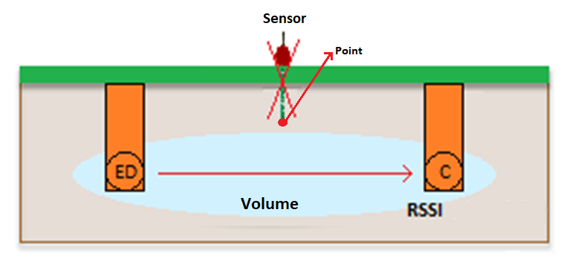

##Packages##

In [1]:
#import packages and files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
from datetime import datetime
from pandas import set_option

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

##Descrizione del dataset

Il database contiene misure di temperatura, salinità ed umidità del terreno presso la biblioteca del dipartimento di agraria a Cadriano. I dati sono stati raccolti tra il 29/03/2021 ed il 04/06/2021. 
Il database contiene:

- *tmsp*: istante in cui viene effettuata la misura
- *rssi*: valore della potenza del segnale ricevuto dal dispositivo 
- *temp_10cm*: temperatura misurata ad una profondità di 10 cm
- *temp_20cm*: temperatura misurata ad una profondità di 20 cm
- *temp_30cm*: temperatura misurata ad una profondità di 30 cm
- *sal_10cm*: salinità misurata ad una profondità di 10 cm
- *sal_20cm*: salinità misurata ad una profondità di 20 cm
- *sal_30cm*: salinità misurata ad una profondità di 30 cm
- *hum_10cm*: umidità misurata ad una profondità di 10 cm
- *hum_20cm*: umidità misurata ad una profondità di 20 cm
- *hum_30cm*: umidità misurata ad una profondità di 30 cm

Il database è disponibile su https://raw.githubusercontent.com/mariniric/cadriano_dataset/main/dataset

E' fondamentale specificare che il terreno in questione è un meleto. In questo caso, infatti, l'attività delle radici delle piante si concentra nell'intorno dei 20-30cm di profondità, di conseguenza risulta fondamentale stimare l'umidità a quella profondità per decidere se irrigare o meno il terreno. 

Inoltre, essendo un campo sperimentale sul quale vengono portate avanti diverse attività, l'umidità del terreno viene comunque tenuta più o meno sotto controllo. Per tale motivo, il dataset non registra enormi variazioni o percentuali di umidità particolarmente alte, in quanto inficerebbero enormemente la crescita delle piante sullo stesso.

In [3]:
#Open dataset from Github
dataset_url='https://raw.githubusercontent.com/mariniric/cadriano_dataset/main/dataset_v2'
column_names=['tmsp','rssi','temp_10cm','temp_20cm','temp_30cm','sal_10cm','sal_20cm','sal_30cm','hum_10cm','hum_20cm','hum_30cm']
dataframe=pd.read_csv(dataset_url, names=column_names, low_memory = True)
dataframe=dataframe.iloc[1:] #drop the first row (labels in the file)

#fix values' types
dataframe['rssi']=pd.to_numeric(dataframe['rssi'])
dataframe['hum_10cm']=pd.to_numeric(dataframe['hum_10cm'])
dataframe['hum_20cm']=pd.to_numeric(dataframe['hum_20cm'])
dataframe['hum_30cm']=pd.to_numeric(dataframe['hum_30cm'])
dataframe['temp_10cm']=pd.to_numeric(dataframe['temp_10cm'])
dataframe['temp_20cm']=pd.to_numeric(dataframe['temp_20cm'])
dataframe['temp_30cm']=pd.to_numeric(dataframe['temp_30cm'])
dataframe['sal_10cm']=pd.to_numeric(dataframe['sal_10cm'])
dataframe['sal_20cm']=pd.to_numeric(dataframe['sal_20cm'])
dataframe['sal_30cm']=pd.to_numeric(dataframe['sal_30cm'])

df_general=dataframe[['rssi','temp_10cm', 'temp_20cm', 'temp_30cm','sal_10cm','sal_20cm','sal_30cm','hum_10cm','hum_20cm','hum_30cm']]
df_10cm=dataframe[['rssi','temp_10cm','sal_10cm', 'hum_10cm']]
df_20cm=dataframe[['rssi','temp_20cm','sal_30cm', 'hum_20cm']]
df_30cm=dataframe[['rssi','temp_30cm','sal_20cm', 'hum_30cm']]

df_general

,rssi,temp_10cm,temp_20cm,temp_30cm,sal_10cm,sal_20cm,sal_30cm,hum_10cm,hum_20cm,hum_30cm
1,-117.2,11.5,10.6,10.9,1335.0,1622.0,1527.0,11.12,37.93,38.63
2,-116.8,12.5,10.7,10.8,1339.0,1623.0,1526.0,11.17,37.91,38.60
3,-116.6,13.5,10.8,10.7,1340.0,1624.0,1527.0,11.24,37.93,38.62
4,-116.6,14.6,10.9,10.8,1352.0,1626.0,1526.0,11.23,37.94,38.56
5,-116.6,16.1,11.1,10.7,1357.0,1628.0,1526.0,11.24,37.95,38.56
...,...,...,...,...,...,...,...,...,...,...
1637,-119.2,24.5,23.7,21.3,1434.0,1628.0,1579.0,10.29,34.03,39.08
1638,-118.8,24.2,23.6,21.5,1430.0,1629.0,1579.0,10.26,34.01,39.08
1639,-118.8,23.9,23.4,21.5,1433.0,1628.0,1579.0,10.24,34.03,39.08
1640,-119.0,23.5,23.4,21.4,1429.0,1623.0,1578.0,10.20,34.00,39.08


##Data Visualization

La cella seguente è utile a visualizzare la distribuzione dei dati

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe4d8f67b90>,
      dtype=object)

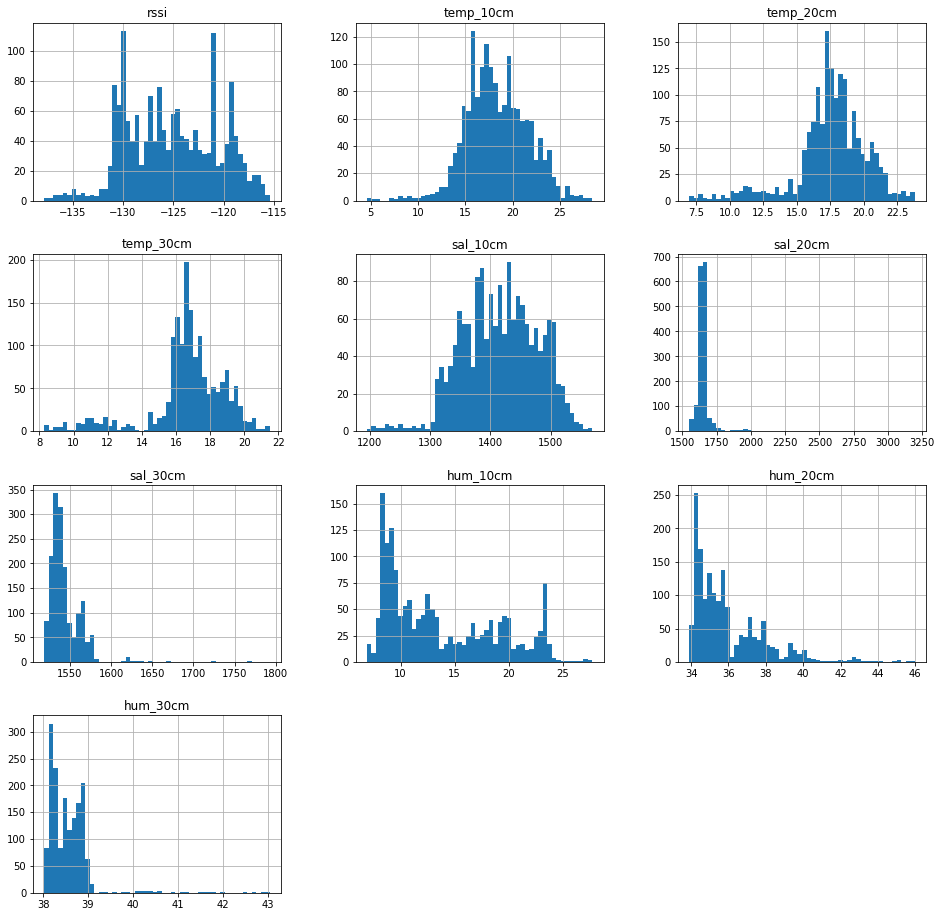

In [4]:
data=df_general #select data to be used

#some statistics
data.hist(bins=50, figsize=(16,16))

In generale, si può notare come l'umidità misurata a 10 cm di profondità sia distribuita in un intervallo molto più grande rispetto ai 20 cm e 30 cm di profondità. Questo avviene principalmente perchè ad una profondità minore il terreno è più influenzato dalle condizioni esterne (e.g., temperatura dell'aria) rispetto a delle profondità maggiori in cui l'attività delle radici delle piante assume un importanza maggiore.

##Useful functions

Vengono definite alcune funzioni utili a creare il modello e graficare alcuni risultati

In [5]:
def plot_history(history,metric=None):
  fig, ax1 = plt.subplots(figsize=(10, 8))
  epoch_count=len(history.history['loss'])
  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['val_loss'],label='val_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_xlim([1,epoch_count])
  ax1.set_ylim([0, max(max(history.history['loss']),max(history.history['val_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  ax1.set_xlabel('Epochs')
  _=ax1.legend(loc='lower left')
  if (metric!=None):
    ax2 = ax1.twinx()
    line2,=ax2.plot(range(1,epoch_count+1),history.history[metric],label='train_'+metric)
    ax2.plot(range(1,epoch_count+1),history.history['val_'+metric],label='val_'+metric,color = line2.get_color(), linestyle = '--')
    ax2.set_ylim([0, max(max(history.history[metric]),max(history.history['val_'+metric]))])
    ax2.set_ylabel(metric,color=line2.get_color())
    ax2.tick_params(axis='y', labelcolor=line2.get_color())
    _=ax2.legend(loc='upper right')

def plot_prediction_results(y,y_pred,output_labels,bin_count=50):
  fig, axs = plt.subplots(2,len(output_labels),figsize=(25, 10),squeeze=False)
  for i in range(len(output_labels)):
    axs[0,i].set_title(output_labels[i])
    axs[0,i].scatter(y[:,i], y_pred[:,i],s=1)
    axs[0,i].set_xlabel('True Values')
    if i==0:
      axs[0,i].set_ylabel('Predictions')
    max_value=max(max(y[:,i]),max(y_pred[:,i]))
    x_lims = [0, max_value]
    y_lims = [min(0,min(y[:,i]),min(y_pred[:,i])), max_value]
    axs[0,i].set_xlim(x_lims)
    axs[0,i].set_ylim(y_lims)
    axs[0,i].plot(y_lims, y_lims, color='k')

    errors = y[:,i]-y_pred[:,i]
    axs[1,i].hist(errors, bins=bin_count)
    axs[1,i].set_xlabel('Prediction Error')
    if i==0:
      axs[1,i].set_ylabel('Count')
    axs[1,i].set_xlim([min(errors),max(errors)])

def plot_prediction_results_single_output(y,y_pred,output_labels,bin_count=50):
  fig, axs = plt.subplots(2,1,figsize=(25, 10),squeeze=False)
  axs[0,0].set_title(output_labels)
  axs[0,0].scatter(y, y_pred,s=1)
  axs[0,0].set_xlabel('True Values')
  axs[0,0].set_ylabel('Predictions')
  max_value=max(max(y),max(y_pred))
  x_lims = [0, max_value]
  y_lims = [min(0,min(y),min(y_pred)), max_value]
  axs[0,0].set_xlim(x_lims)
  axs[0,0].set_ylim(y_lims)
  axs[0,0].plot(y_lims, y_lims, color='k')

  print(y.shape)
  print(y_pred.shape)
  errors = y-y_pred[:,0]
  axs[1,0].hist(errors, bins=bin_count)
  axs[1,0].set_xlabel('Prediction Error')
  axs[1,0].set_ylabel('Count')
  axs[1,0].set_xlim([min(errors),max(errors)])

#plot_history(history,'rmse')

In [6]:
#Build model

def build_dnn(input_count,output_count,neuron_count_per_hidden_layer,activation='relu'):
  model = keras.Sequential()
  model.add(layers.Input(shape=(input_count)))
  for n in neuron_count_per_hidden_layer:
    model.add(layers.Dense(n,activation=activation))
  model.add(layers.Dense(output_count))
  return model

##Obiettivo 1: Stima dell'umidità (multi-depth model)
L'obiettivo iniziale del progetto è realizzare una rete neurale che, presi in input RSSI, salinità e temperatura del terreno, possa predire l'umidità del terreno per le tre diverse profondità considerate.


In [7]:
#Prepare data

array = data.values
X = array[:,0:7] #RSSI, temp10, temp20, temp30, sal10, sal20, sal30
Y = array[:,7:10] #hum10, hum20, hum30
print('Printing data shapes before splitting...')
print('Feature shape: ',X.shape)
print('Target shape: ',Y.shape)

# train-test splitting
test_size = 0.33
seed = 7
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#train-validation splitting
val_size=0.25
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_size, random_state=1,shuffle=True)

print('\nPrinting data shapes after splitting...')
print('Train feature shape: ',x_train.shape)
print('Train target shape: ',y_train.shape)
print('Validation feature shape: ',x_val.shape)
print('Validation target shape: ',y_val.shape)
print('Test feature shape: ',x_test.shape)
print('Test target shape: ',y_test.shape)

Printing data shapes before splitting...
Feature shape:  (1641, 7)
Target shape:  (1641, 3)

Printing data shapes after splitting...
Train feature shape:  (824, 7)
Train target shape:  (824, 3)
Validation feature shape:  (275, 7)
Validation target shape:  (275, 3)
Test feature shape:  (542, 7)
Test target shape:  (542, 3)


In [9]:
#Data normalization
scaler = StandardScaler().fit(x_train)
train_x = scaler.transform(x_train)
val_x=scaler.transform(x_val)
test_x = scaler.transform(x_test)

In [10]:
#Run model
epoch_count = 2000
batch_size = 100
learning_rate= 0.0001
patience= 20

dnn_multi_depth=build_dnn(x_train.shape[1],y_train.shape[1], [256, 128, 64, 32])
dnn_multi_depth.summary()

#optimizer=keras.optimizers.SGD(learning_rate=learning_rate)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
dnn_multi_depth.compile(loss='mse', optimizer=optimizer,metrics=[keras.metrics.RootMeanSquaredError(name='rmse')])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

history = dnn_multi_depth.fit(x_train, y_train,validation_data=(x_val,y_val), epochs=epoch_count, batch_size=batch_size,shuffle = True,callbacks=[early_stop])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2048      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 45,379
Trainable params: 45,379
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
9/9 [==============================] - 

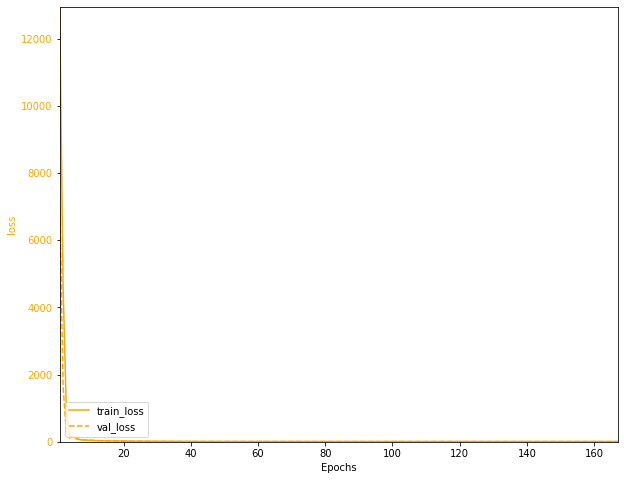

In [11]:
#Plot loss history

plot_history(history)

Train predictions shape:  (824, 3)
Validation predictions shape:  (275, 3)
Test predictions shape:  (542, 3)
RMSE - Train: 2.140 Val: 2.161 Test: 2.126


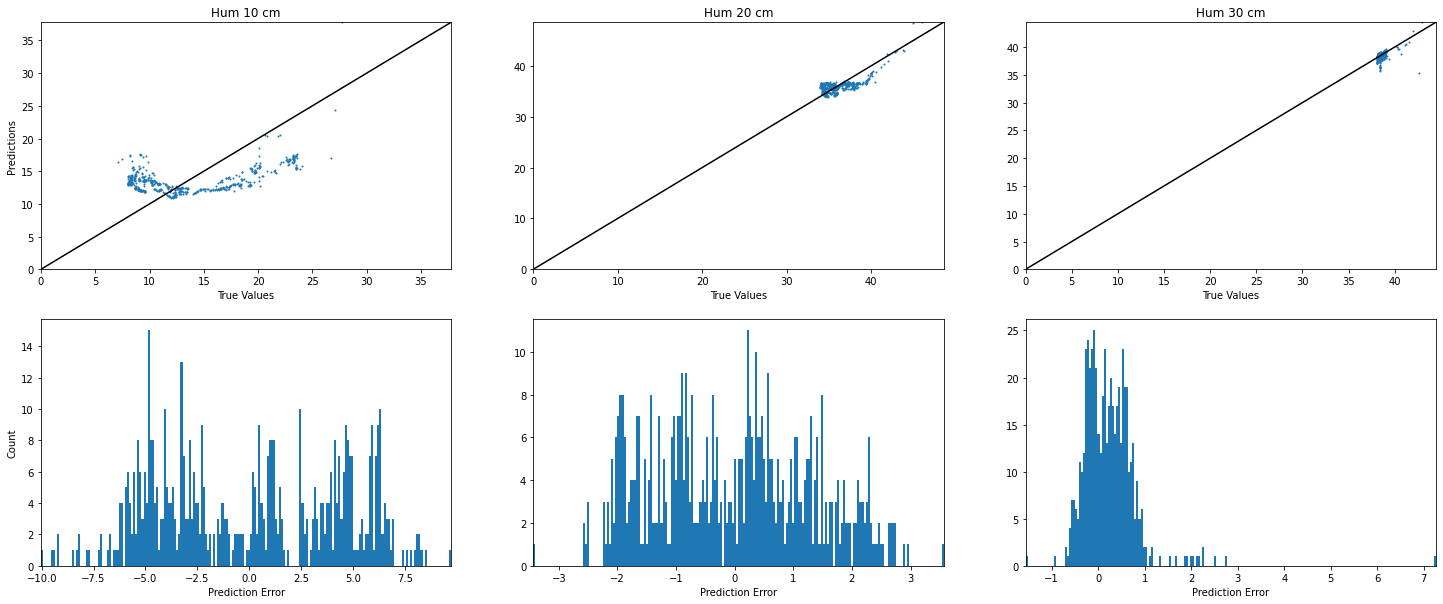

In [12]:
#Test model

train_y_pred=dnn_multi_depth.predict(x_train)
val_y_pred=dnn_multi_depth.predict(x_val)
test_y_pred=dnn_multi_depth.predict(x_test)

print('Train predictions shape: ',train_y_pred.shape)
print('Validation predictions shape: ',val_y_pred.shape)
print('Test predictions shape: ',test_y_pred.shape)

rmse_train = mean_squared_error(y_train,train_y_pred,squared=False)
rmse_val = mean_squared_error(y_val,val_y_pred,squared=False)
rmse_test = mean_squared_error(y_test,test_y_pred,squared=False)

print('RMSE - Train: {:.3f} Val: {:.3f} Test: {:.3f}'.format(rmse_train,rmse_val,rmse_test))

target_data=['Hum 10 cm', 'Hum 20 cm', 'Hum 30 cm']
plot_prediction_results(y_test,test_y_pred,target_data,200)

Il modello sembra predire con sufficiente accuratezza l'umidità a profondità più elevate, mentre fa molta fatica a stimare l'umidità del terreno a 10 cm di profondità. Questo certifica il fatto che a tale profondità non è sufficiente utilizzare dati relativi al terreno, ma parametri esterni (e.g., aria) assumono una loro importanza.
 
E' importante sottolineare come la decisione di irrigare o meno, che dipende dall'umidità misurata soprattutto a profondità più elevate, non abbia bisogno di una precisione al decimo o centesimo dell'unità, ma è sufficiente che sia stimata correttamente nell'intorno dell'1-2%.

##Obiettivo 2: Stima dell'umidità senza l'utilizzo di altri sensori nel campo (RSSI only)
Il secondo obiettivo del progetto è valutare cosa succederebbe se non ci fossero altri sensori nel campo a meno della coppia trasmettitore/ricevitore per valutare RSSI. Ciò comporterebbe un risparmio economico notevole in quanto non ci sarebbe necessità di aggiungere altri sensori nel campo.

In [13]:
#prepare data
array = data.values
X = array[:,0].transpose() #RSSI
Y = array[:,7:10] #hum10, hum20, hum30
print('Printing data shapes before splitting...')
print('Feature shape: ',X.shape)
print('Target shape: ',Y.shape)

# train-test splitting
test_size = 0.33
seed = 7
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#train-validation splitting
val_size=0.25
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_size, random_state = 1,shuffle=True)

print('\nPrinting data shapes after splitting...')
print('Train feature shape: ',x_train.shape)
print('Train target shape: ',y_train.shape)
print('Validation feature shape: ',x_val.shape)
print('Validation target shape: ',y_val.shape)
print('Test feature shape: ',x_test.shape)
print('Test target shape: ',y_test.shape)

Printing data shapes before splitting...
Feature shape:  (1641,)
Target shape:  (1641, 3)

Printing data shapes after splitting...
Train feature shape:  (824,)
Train target shape:  (824, 3)
Validation feature shape:  (275,)
Validation target shape:  (275, 3)
Test feature shape:  (542,)
Test target shape:  (542, 3)


In [14]:
#Run model

epoch_count = 2000
batch_size = 100
learning_rate= 0.0001
patience= 20

dnn_rssi_only=build_dnn(1, y_train.shape[1], [256, 128, 64, 32])
dnn_rssi_only.summary()

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
dnn_rssi_only.compile(loss='mse', optimizer=optimizer,metrics=[keras.metrics.RootMeanSquaredError(name='rmse')])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

history = dnn_rssi_only.fit(x_train, y_train,validation_data=(x_val,y_val), epochs=epoch_count, batch_size=batch_size,shuffle = True,callbacks=[early_stop])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               512       
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 3)                 99        
                                                                 
Total params: 43,843
Trainable params: 43,843
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
9/9 [==============================] 

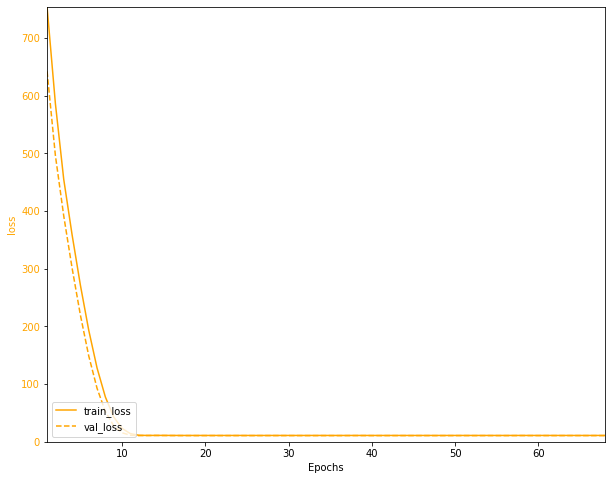

In [15]:
plot_history(history)

Train predictions shape:  (824, 3)
Validation predictions shape:  (275, 3)
Test predictions shape:  (542, 3)
RMSE - Train: 2.942 Val: 2.934 Test: 2.849


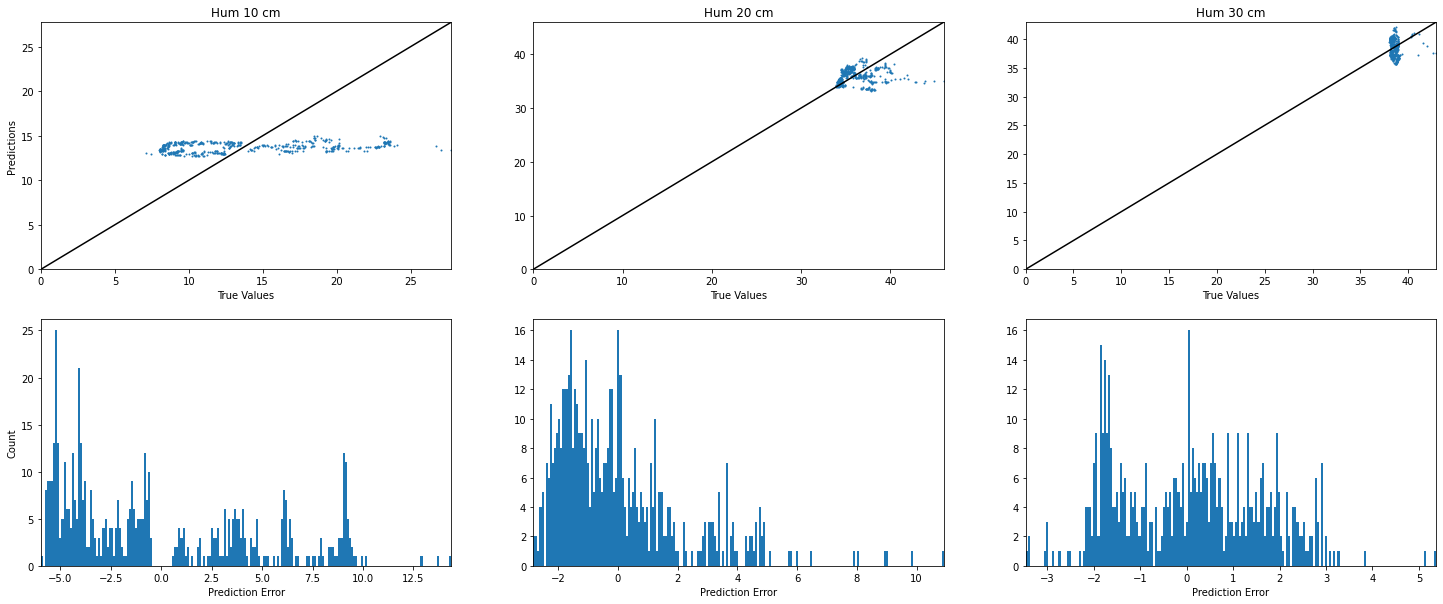

In [16]:
train_y_pred=dnn_rssi_only.predict(x_train)
val_y_pred=dnn_rssi_only.predict(x_val)
test_y_pred=dnn_rssi_only.predict(x_test)

print('Train predictions shape: ',train_y_pred.shape)
print('Validation predictions shape: ',val_y_pred.shape)
print('Test predictions shape: ',test_y_pred.shape)

rmse_train = mean_squared_error(y_train,train_y_pred,squared=False)
rmse_val = mean_squared_error(y_val,val_y_pred,squared=False)
rmse_test = mean_squared_error(y_test,test_y_pred,squared=False)

print('RMSE - Train: {:.3f} Val: {:.3f} Test: {:.3f}'.format(rmse_train,rmse_val,rmse_test))

target_data=['Hum 10 cm', 'Hum 20 cm', 'Hum 30 cm']
plot_prediction_results(y_test,test_y_pred,target_data,200)

Come ci si poteva aspettare, l'utilizzo esclusivo della misura di RSSI introduce un peggioramento nel modello, in quanto il RMSE sul test set passa da 2.126 a 2.849. E' ancora più evidente la problematica nella stima dell'umidità ad una profondità del 10 cm e si nota come ci sia una minor correlazione tra l'umidità e RSSI a questo livello. 

A 20 e 30 cm invece il modello risulta ancora utilizzabile. Probabilmente l'incremento dell'intervallo di valori misurati all'interno del terreno permetterebbe meglio di allenare un modello ancor più preciso che potrebbe utilizzare esclusivamente l'RSSI come input, eliminando completamente la necessità di altri sensori.

#Obiettivo 3: Valutazione multi-depth model vs single-depth model

Essendoci molte difficoltà a stimare l'umidità a 10 cm di profondità, un'analisi interessante riguarda la valutazione di eventuali differenze nell'allenare un modello specializzato a stimare l'umidità esclusivamente ad una profondità prestabilità (single-depth) rispetto ad un modello multi-depth.

Depth = 30 cm

In [30]:
#prepare data
data=df_30cm
array = data.values
X = array[:,0:3] 
Y = array[:,3] 
print('Printing data shapes before splitting...')
print('Feature shape: ',X.shape)
print('Target shape: ',Y.shape)

# train-test splitting
test_size = 0.33
seed = 7
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#train-validation splitting
val_size=0.25
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_size, random_state = 1,shuffle=True)

print('\nPrinting data shapes after splitting...')
print('Train feature shape: ',x_train.shape)
print('Train target shape: ',y_train.shape)
print('Validation feature shape: ',x_val.shape)
print('Validation target shape: ',y_val.shape)
print('Test feature shape: ',x_test.shape)
print('Test target shape: ',y_test.shape)

#Data normalization

scaler = StandardScaler().fit(x_train)
train_x = scaler.transform(x_train)
val_x=scaler.transform(x_val)
test_x = scaler.transform(x_test)

Printing data shapes before splitting...
Feature shape:  (1641, 3)
Target shape:  (1641,)

Printing data shapes after splitting...
Train feature shape:  (824, 3)
Train target shape:  (824,)
Validation feature shape:  (275, 3)
Validation target shape:  (275,)
Test feature shape:  (542, 3)
Test target shape:  (542,)


In [31]:
#Run model

epoch_count = 2000
batch_size = 100
learning_rate= 0.0001
patience=20

dnn_30cm=build_dnn(x_train.shape[1],1, [128, 64, 32])
dnn_30cm.summary()

optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
dnn_30cm.compile(loss='mse', optimizer=optimizer,metrics=[keras.metrics.RootMeanSquaredError(name='rmse')])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

history = dnn_30cm.fit(x_train, y_train,validation_data=(x_val,y_val), epochs=epoch_count, batch_size=batch_size,shuffle = True,callbacks=[early_stop])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 128)               512       
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 10,881
Trainable params: 10,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
9/9 [==============================] - 2s 110ms/step - loss: 16713.2539 - rmse: 129.2798 - val_loss: 6950.7832 - val_rmse: 83.3714
Epoch 2/2000
9/9 [====================

Train predictions shape:  (824, 1)
Validation predictions shape:  (275, 1)
Test predictions shape:  (542, 1)
RMSE - Train: 0.845 Val: 0.879 Test: 0.865
(542,)
(542, 1)


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


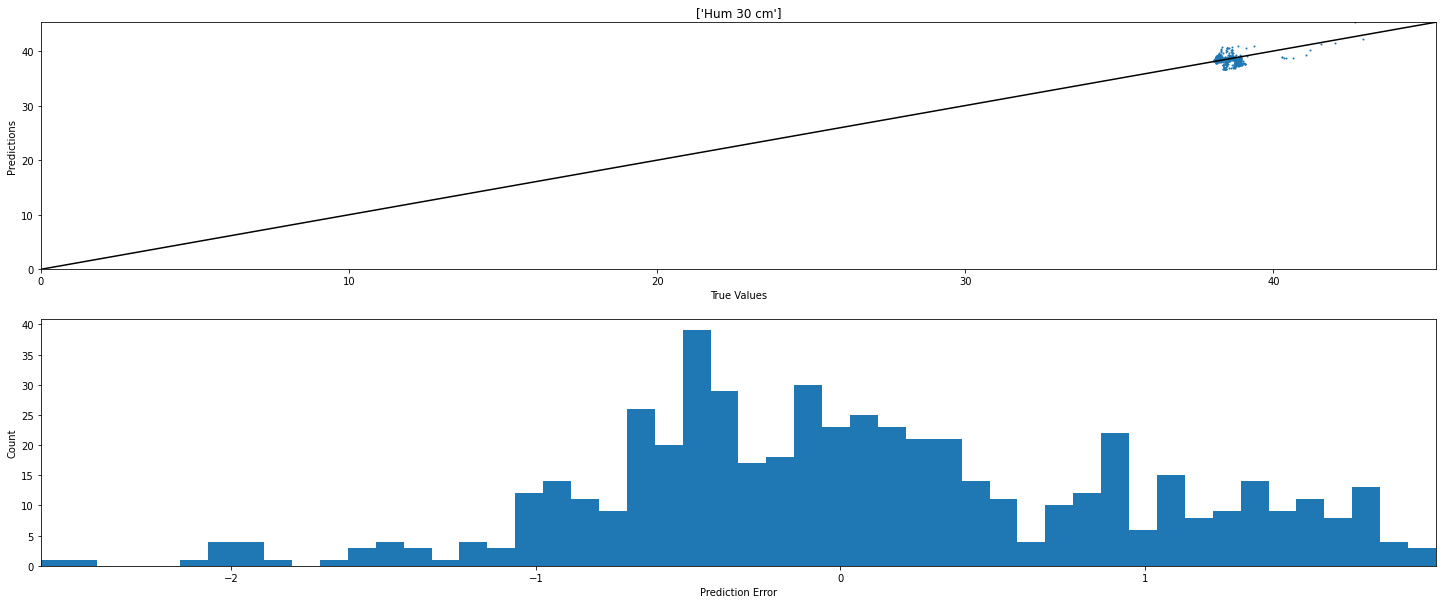

In [32]:
train_y_pred=dnn_30cm.predict(x_train)
val_y_pred=dnn_30cm.predict(x_val)
test_y_pred=dnn_30cm.predict(x_test)

print('Train predictions shape: ',train_y_pred.shape)
print('Validation predictions shape: ',val_y_pred.shape)
print('Test predictions shape: ',test_y_pred.shape)

rmse_train_30cm = mean_squared_error(y_train,train_y_pred,squared=False)
rmse_val_30cm = mean_squared_error(y_val,val_y_pred,squared=False)
rmse_test_30cm = mean_squared_error(y_test,test_y_pred,squared=False)

print('RMSE - Train: {:.3f} Val: {:.3f} Test: {:.3f}'.format(rmse_train_30cm, rmse_val_30cm, rmse_test_30cm))

target_data=['Hum 30 cm']
plot_prediction_results_single_output(y_test,test_y_pred,target_data)

Depth = 20 cm

In [27]:
#prepare data
data=df_20cm
array = data.values
X = array[:,0:3] 
Y = array[:,3] 
print('Printing data shapes before splitting...')
print('Feature shape: ',X.shape)
print('Target shape: ',Y.shape)

# train-test splitting
test_size = 0.33
seed = 7
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#train-validation splitting
val_size=0.25
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_size, random_state = 1,shuffle=True)

print('\nPrinting data shapes after splitting...')
print('Train feature shape: ',x_train.shape)
print('Train target shape: ',y_train.shape)
print('Validation feature shape: ',x_val.shape)
print('Validation target shape: ',y_val.shape)
print('Test feature shape: ',x_test.shape)
print('Test target shape: ',y_test.shape)

#Data normalization

scaler = StandardScaler().fit(x_train)
train_x = scaler.transform(x_train)
val_x=scaler.transform(x_val)
test_x = scaler.transform(x_test)

Printing data shapes before splitting...
Feature shape:  (1641, 3)
Target shape:  (1641,)

Printing data shapes after splitting...
Train feature shape:  (824, 3)
Train target shape:  (824,)
Validation feature shape:  (275, 3)
Validation target shape:  (275,)
Test feature shape:  (542, 3)
Test target shape:  (542,)


In [28]:
#Run model

epoch_count = 2000
batch_size = 100
learning_rate= 0.0001
patience=20

dnn_20cm=build_dnn(x_train.shape[1],1, [128, 64, 32])
dnn_20cm.summary()

optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
dnn_20cm.compile(loss='mse', optimizer=optimizer,metrics=[keras.metrics.RootMeanSquaredError(name='rmse')])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

history = dnn_20cm.fit(x_train, y_train,validation_data=(x_val,y_val), epochs=epoch_count, batch_size=batch_size,shuffle = True,callbacks=[early_stop])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 128)               512       
                                                                 
 dense_29 (Dense)            (None, 64)                8256      
                                                                 
 dense_30 (Dense)            (None, 32)                2080      
                                                                 
 dense_31 (Dense)            (None, 1)                 33        
                                                                 
Total params: 10,881
Trainable params: 10,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
9/9 [==============================] - 1s 35ms/step - loss: 3837.0635 - rmse: 61.9440 - val_loss: 1453.0038 - val_rmse: 38.1183
Epoch 2/2000
9/9 [=======================

Train predictions shape:  (824, 1)
Validation predictions shape:  (275, 1)
Test predictions shape:  (542, 1)
RMSE - Train: 1.893 Val: 2.029 Test: 1.764
(542,)
(542, 1)


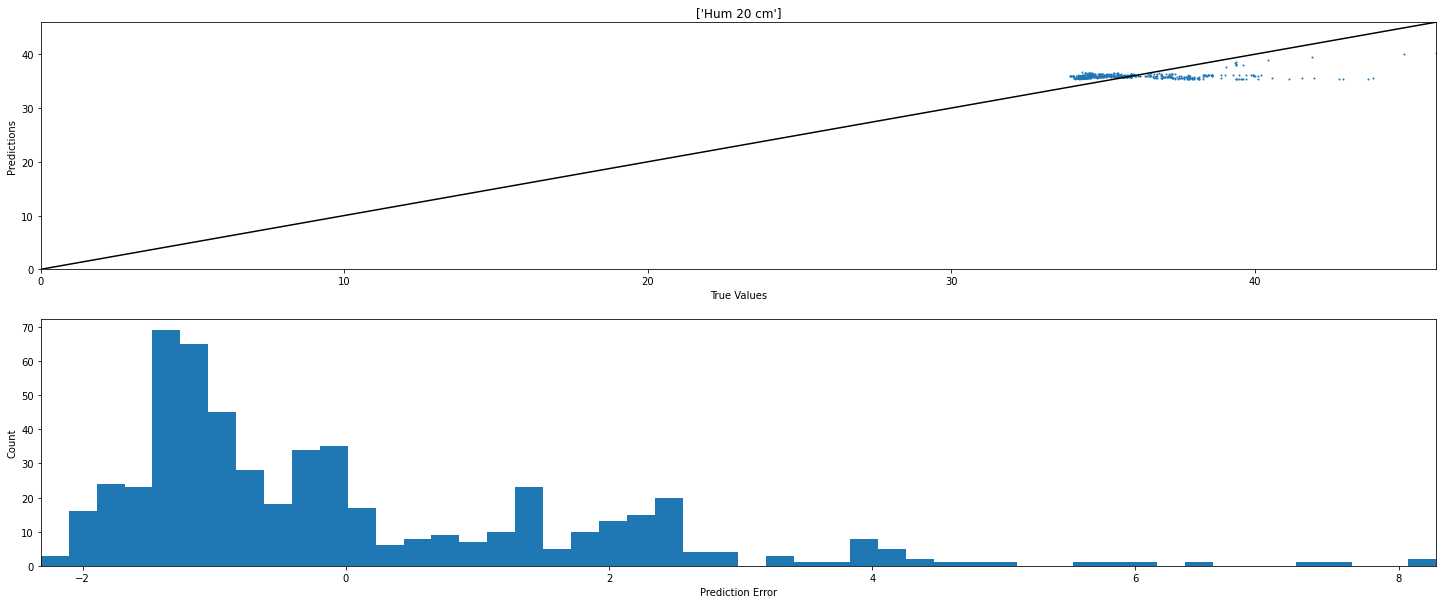

In [29]:
train_y_pred=dnn_20cm.predict(x_train)
val_y_pred=dnn_20cm.predict(x_val)
test_y_pred=dnn_20cm.predict(x_test)

print('Train predictions shape: ',train_y_pred.shape)
print('Validation predictions shape: ',val_y_pred.shape)
print('Test predictions shape: ',test_y_pred.shape)

rmse_train_20cm = mean_squared_error(y_train,train_y_pred,squared=False)
rmse_val_20cm = mean_squared_error(y_val,val_y_pred,squared=False)
rmse_test_20cm = mean_squared_error(y_test,test_y_pred,squared=False)

print('RMSE - Train: {:.3f} Val: {:.3f} Test: {:.3f}'.format(rmse_train_20cm, rmse_val_20cm, rmse_test_20cm))

target_data=['Hum 20 cm']
plot_prediction_results_single_output(y_test,test_y_pred,target_data)

Depth = 10 cm

In [23]:
#prepare data
data=df_10cm
array = data.values
X = array[:,0:3] 
Y = array[:,3] 
print('Printing data shapes before splitting...')
print('Feature shape: ',X.shape)
print('Target shape: ',Y.shape)

# train-test splitting
test_size = 0.33
seed = 7
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#train-validation splitting
val_size=0.25
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_size, random_state = 1,shuffle=True)

print('\nPrinting data shapes after splitting...')
print('Train feature shape: ',x_train.shape)
print('Train target shape: ',y_train.shape)
print('Validation feature shape: ',x_val.shape)
print('Validation target shape: ',y_val.shape)
print('Test feature shape: ',x_test.shape)
print('Test target shape: ',y_test.shape)

#Data normalization
scaler = StandardScaler().fit(x_train)
train_x = scaler.transform(x_train)
val_x=scaler.transform(x_val)
test_x = scaler.transform(x_test)

Printing data shapes before splitting...
Feature shape:  (1641, 3)
Target shape:  (1641,)

Printing data shapes after splitting...
Train feature shape:  (824, 3)
Train target shape:  (824,)
Validation feature shape:  (275, 3)
Validation target shape:  (275,)
Test feature shape:  (542, 3)
Test target shape:  (542,)


In [25]:
#Run model

epoch_count = 2000
batch_size = 50
learning_rate= 0.001
patience=20

dnn_10cm=build_dnn(x_train.shape[1],1, [128, 64, 32])
dnn_10cm.summary()

optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
dnn_10cm.compile(loss='mse', optimizer=optimizer,metrics=[keras.metrics.RootMeanSquaredError(name='rmse')])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

history = dnn_10cm.fit(x_train, y_train,validation_data=(x_val,y_val), epochs=epoch_count, batch_size=batch_size,shuffle = True, callbacks=[early_stop])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               512       
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
Total params: 10,881
Trainable params: 10,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
17/17 [==============================] - 1s 18ms/step - loss: 3013.8926 - rmse: 54.8989 - val_loss: 488.1741 - val_rmse: 22.0947
Epoch 2/2000
17/17 [====================

Train predictions shape:  (824, 1)
Validation predictions shape:  (275, 1)
Test predictions shape:  (542, 1)
RMSE - Train: 5.054 Val: 4.810 Test: 4.838
(542,)
(542, 1)


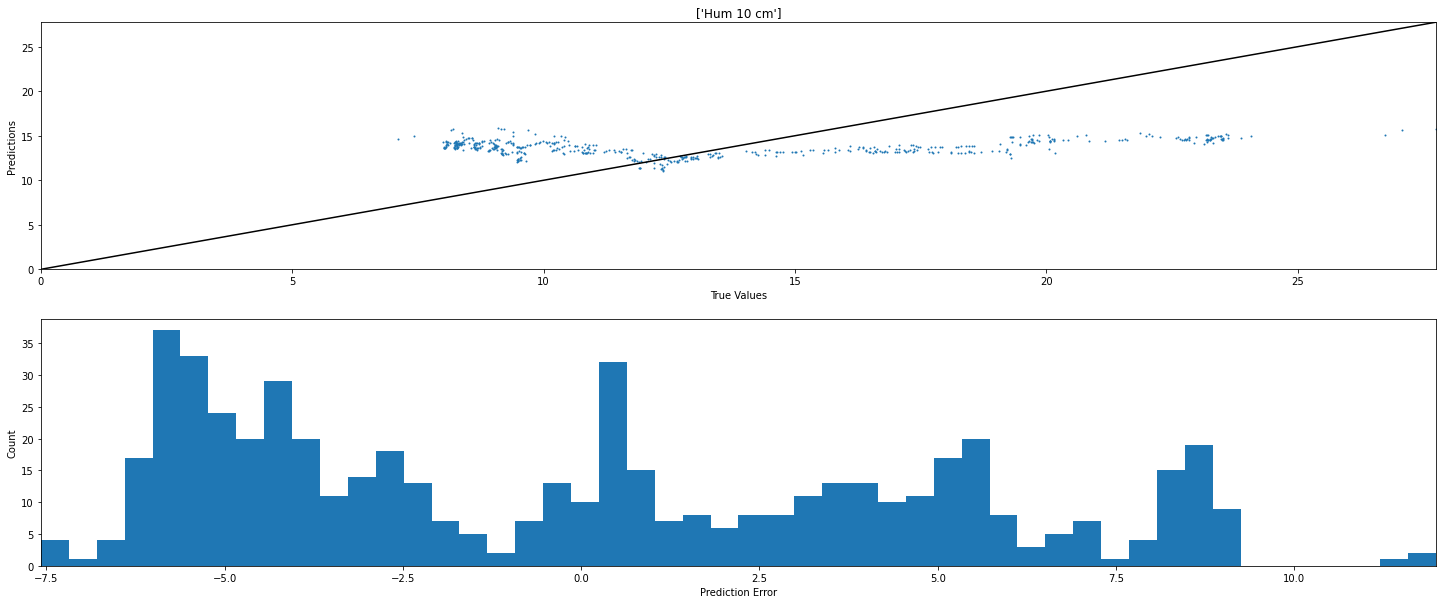

In [26]:
train_y_pred=dnn_10cm.predict(x_train)
val_y_pred=dnn_10cm.predict(x_val)
test_y_pred=dnn_10cm.predict(x_test)

print('Train predictions shape: ',train_y_pred.shape)
print('Validation predictions shape: ',val_y_pred.shape)
print('Test predictions shape: ',test_y_pred.shape)

rmse_train_10cm = mean_squared_error(y_train,train_y_pred,squared=False)
rmse_val_10cm = mean_squared_error(y_val,val_y_pred,squared=False)
rmse_test_10cm = mean_squared_error(y_test,test_y_pred,squared=False)

print('RMSE - Train: {:.3f} Val: {:.3f} Test: {:.3f}'.format(rmse_train_10cm, rmse_val_10cm, rmse_test_10cm))

target_data=['Hum 10 cm']
plot_prediction_results_single_output(y_test,test_y_pred,target_data)

In generale, il training di un modello ad una profondità singola sembra offrire una maggior precisione rispetto al modello multi-depth. In particolare, il RMSE valutato sul test set a 20 cm e 30 cm di profondità (1.764 e 0.865 rispettivamente) risulta essere più basso di quello misurato tramite il modello multi-depth.

Nonostante ciò, i valori di umidità a 10 cm di profondità continuano a risultare particolarmente difficili da stimare e l'errore introdotto è abbastanza importante (RMSE=4.838). Giunto a questo punto, ritengo di poter affermare che difficilmente, con i dati a mia disposizione, posso allenare un modello in grado di predire tutte le profondità con la stessa precisione e che, più in generale, il comportamento delle misure a 10 cm di profondità è troppo diverso rispetto alle altre, rendendo difficile trovare una correlazione utile tra i dati.

#Obiettivo 4: Valutazione del single depth model su diverse profondità

L'ultimo obiettivo del progetto è osservare cosa succede se si utilizza un modello addestrato su una singola profondità su un test set con dati di profondità diverse.

Depth=30 cm

Printing data shapes before splitting...
Feature shape:  (1641, 3)
Target shape:  (1641,)

Printing data shapes after splitting...
Train feature shape:  (824, 3)
Train target shape:  (824,)
Validation feature shape:  (275, 3)
Validation target shape:  (275,)
Test feature shape:  (542, 3)
Test target shape:  (542,)
Train predictions shape:  (824, 1)
Validation predictions shape:  (275, 1)
Test predictions shape:  (542, 1)
RMSE - Train: 1.923 Val: 2.045 Test: 1.807
(542,)
(542, 1)


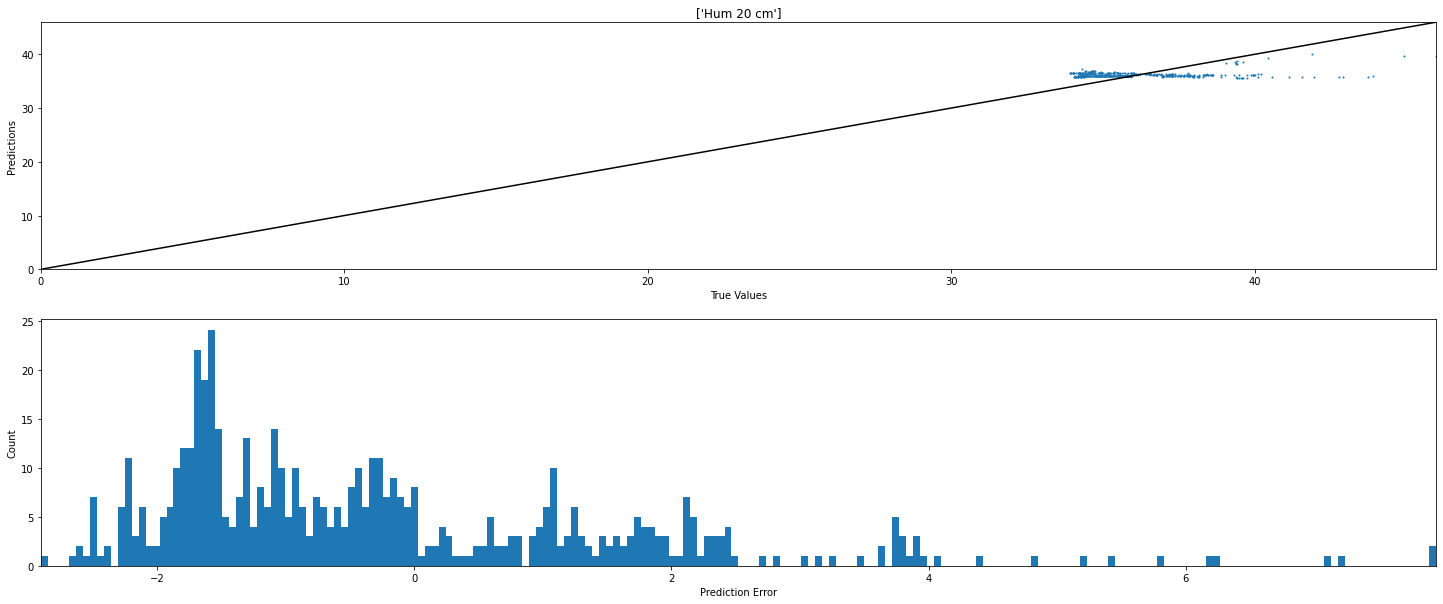

In [33]:
#DNN 30 cm over 20 cm

#prepare data
data=df_20cm
array = data.values
X = array[:,[0,1,2]]
Y = array[:,3]
print('Printing data shapes before splitting...')
print('Feature shape: ',X.shape)
print('Target shape: ',Y.shape)

# train-test splitting
test_size = 0.33
seed = 7
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#train-validation splitting
val_size=0.25
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_size, random_state = 1,shuffle=True)

print('\nPrinting data shapes after splitting...')
print('Train feature shape: ',x_train.shape)
print('Train target shape: ',y_train.shape)
print('Validation feature shape: ',x_val.shape)
print('Validation target shape: ',y_val.shape)
print('Test feature shape: ',x_test.shape)
print('Test target shape: ',y_test.shape)

train_y_pred=dnn_30cm.predict(x_train)
val_y_pred=dnn_30cm.predict(x_val)
test_y_pred=dnn_30cm.predict(x_test)

print('Train predictions shape: ',train_y_pred.shape)
print('Validation predictions shape: ',val_y_pred.shape)
print('Test predictions shape: ',test_y_pred.shape)

rmse_train_dnn_30cm_over_20cm = mean_squared_error(y_train,train_y_pred,squared=False)
rmse_val_dnn_30cm_over_20cm = mean_squared_error(y_val,val_y_pred,squared=False)
rmse_test_dnn_30cm_over_20cm = mean_squared_error(y_test,test_y_pred,squared=False)

print('RMSE - Train: {:.3f} Val: {:.3f} Test: {:.3f}'.format(rmse_train_dnn_30cm_over_20cm, rmse_val_dnn_30cm_over_20cm, rmse_test_dnn_30cm_over_20cm))

target_data=['Hum 20 cm']
plot_prediction_results_single_output(y_test,test_y_pred,target_data,200)

Printing data shapes before splitting...
Feature shape:  (1641, 3)
Target shape:  (1641,)

Printing data shapes after splitting...
Train feature shape:  (824, 3)
Train target shape:  (824,)
Validation feature shape:  (275, 3)
Validation target shape:  (275,)
Test feature shape:  (542, 3)
Test target shape:  (542,)
Train predictions shape:  (824, 1)
Validation predictions shape:  (275, 1)
Test predictions shape:  (542, 1)
RMSE - Train: 20.148 Val: 20.252 Test: 20.260
(542,)
(542, 1)


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


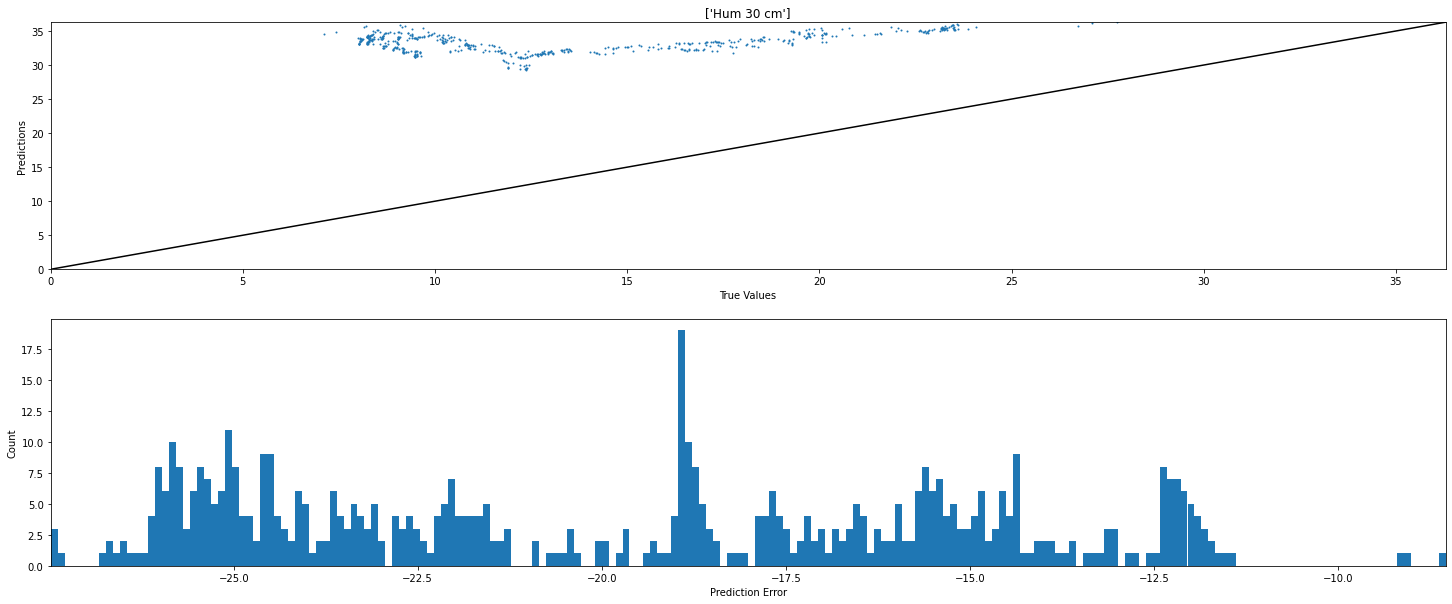

In [34]:
#DNN 30 cm over 10 cm

#prepare data
data=df_10cm
array = data.values
X = array[:,[0,1,2]] 
Y = array[:,3] 
print('Printing data shapes before splitting...')
print('Feature shape: ',X.shape)
print('Target shape: ',Y.shape)

# train-test splitting
test_size = 0.33
seed = 7
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#train-validation splitting
val_size=0.25
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_size, random_state = 1,shuffle=True)

print('\nPrinting data shapes after splitting...')
print('Train feature shape: ',x_train.shape)
print('Train target shape: ',y_train.shape)
print('Validation feature shape: ',x_val.shape)
print('Validation target shape: ',y_val.shape)
print('Test feature shape: ',x_test.shape)
print('Test target shape: ',y_test.shape)

train_y_pred=dnn_30cm.predict(x_train)
val_y_pred=dnn_30cm.predict(x_val)
test_y_pred=dnn_30cm.predict(x_test)

print('Train predictions shape: ',train_y_pred.shape)
print('Validation predictions shape: ',val_y_pred.shape)
print('Test predictions shape: ',test_y_pred.shape)

rmse_train_dnn_30cm_over_10cm = mean_squared_error(y_train,train_y_pred,squared=False)
rmse_val_dnn_30cm_over_10cm = mean_squared_error(y_val,val_y_pred,squared=False)
rmse_test_dnn_30cm_over_10cm = mean_squared_error(y_test,test_y_pred,squared=False)

print('RMSE - Train: {:.3f} Val: {:.3f} Test: {:.3f}'.format(rmse_train_dnn_30cm_over_10cm,rmse_val_dnn_30cm_over_10cm,rmse_test_dnn_30cm_over_10cm))

target_data=['Hum 30 cm']
plot_prediction_results_single_output(y_test,test_y_pred,target_data,200)

Depth = 20 cm

Printing data shapes before splitting...
Feature shape:  (1641, 3)
Target shape:  (1641,)

Printing data shapes after splitting...
Train feature shape:  (824, 3)
Train target shape:  (824,)
Validation feature shape:  (275, 3)
Validation target shape:  (275,)
Test feature shape:  (542, 3)
Test target shape:  (542,)
Train predictions shape:  (824, 1)
Validation predictions shape:  (275, 1)
Test predictions shape:  (542, 1)
RMSE - Train: 1.522 Val: 2.105 Test: 1.612
(542,)
(542, 1)


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


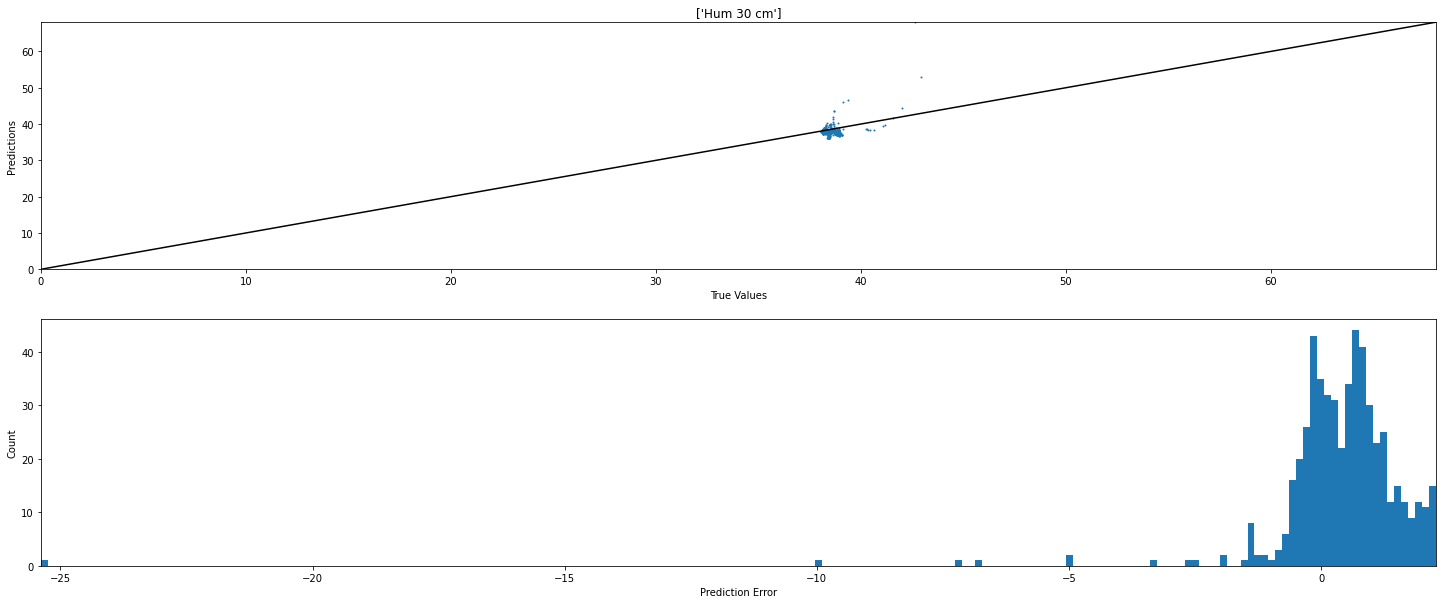

In [36]:
#DNN 20 cm over 30 cm

#prepare data
data=df_30cm
array = data.values
X = array[:,[0,1,2]] 
Y = array[:,3] 
print('Printing data shapes before splitting...')
print('Feature shape: ',X.shape)
print('Target shape: ',Y.shape)

# train-test splitting
test_size = 0.33
seed = 7
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#train-validation splitting
val_size=0.25
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_size, random_state = 1,shuffle=True)

print('\nPrinting data shapes after splitting...')
print('Train feature shape: ',x_train.shape)
print('Train target shape: ',y_train.shape)
print('Validation feature shape: ',x_val.shape)
print('Validation target shape: ',y_val.shape)
print('Test feature shape: ',x_test.shape)
print('Test target shape: ',y_test.shape)

train_y_pred=dnn_20cm.predict(x_train)
val_y_pred=dnn_20cm.predict(x_val)
test_y_pred=dnn_20cm.predict(x_test)

print('Train predictions shape: ',train_y_pred.shape)
print('Validation predictions shape: ',val_y_pred.shape)
print('Test predictions shape: ',test_y_pred.shape)

rmse_train_dnn_20cm_over_30cm = mean_squared_error(y_train,train_y_pred,squared=False)
rmse_val_dnn_20cm_over_30cm = mean_squared_error(y_val,val_y_pred,squared=False)
rmse_test_dnn_20cm_over_30cm = mean_squared_error(y_test,test_y_pred,squared=False)

print('RMSE - Train: {:.3f} Val: {:.3f} Test: {:.3f}'.format(rmse_train_dnn_20cm_over_30cm,rmse_val_dnn_20cm_over_30cm,rmse_test_dnn_20cm_over_30cm))

target_data=['Hum 30 cm']
plot_prediction_results_single_output(y_test,test_y_pred,target_data,200)

Printing data shapes before splitting...
Feature shape:  (1641, 3)
Target shape:  (1641,)

Printing data shapes after splitting...
Train feature shape:  (824, 3)
Train target shape:  (824,)
Validation feature shape:  (275, 3)
Validation target shape:  (275,)
Test feature shape:  (542, 3)
Test target shape:  (542,)
Train predictions shape:  (824, 1)
Validation predictions shape:  (275, 1)
Test predictions shape:  (542, 1)
RMSE - Train: 20.200 Val: 20.323 Test: 20.331
(542,)
(542, 1)


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


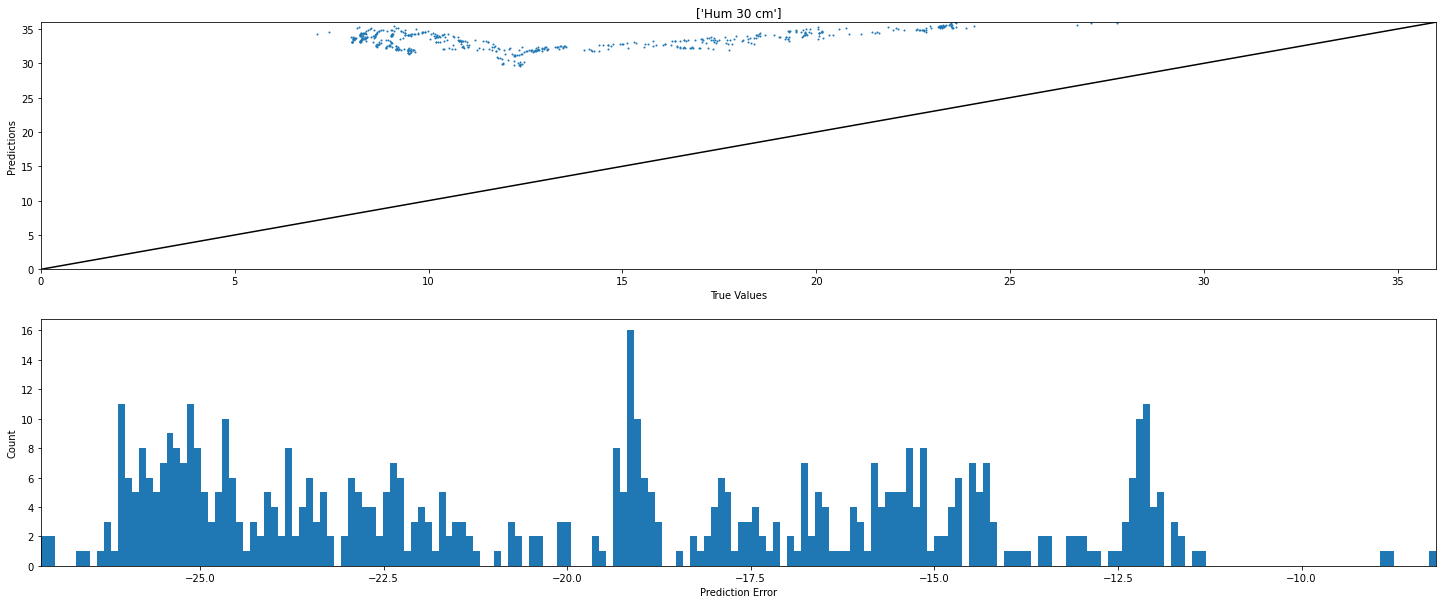

In [37]:
#DNN 20 cm over 10 cm

#prepare data
data=df_10cm
array = data.values
X = array[:,[0,1,2]] 
Y = array[:,3]
print('Printing data shapes before splitting...')
print('Feature shape: ',X.shape)
print('Target shape: ',Y.shape)

# train-test splitting
test_size = 0.33
seed = 7
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#train-validation splitting
val_size=0.25
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_size, random_state = 1,shuffle=True)

print('\nPrinting data shapes after splitting...')
print('Train feature shape: ',x_train.shape)
print('Train target shape: ',y_train.shape)
print('Validation feature shape: ',x_val.shape)
print('Validation target shape: ',y_val.shape)
print('Test feature shape: ',x_test.shape)
print('Test target shape: ',y_test.shape)

train_y_pred=dnn_20cm.predict(x_train)
val_y_pred=dnn_20cm.predict(x_val)
test_y_pred=dnn_20cm.predict(x_test)

print('Train predictions shape: ',train_y_pred.shape)
print('Validation predictions shape: ',val_y_pred.shape)
print('Test predictions shape: ',test_y_pred.shape)

rmse_train_dnn_20cm_over_10cm = mean_squared_error(y_train,train_y_pred,squared=False)
rmse_val_dnn_20cm_over_10cm = mean_squared_error(y_val,val_y_pred,squared=False)
rmse_test_dnn_20cm_over_10cm = mean_squared_error(y_test,test_y_pred,squared=False)

print('RMSE - Train: {:.3f} Val: {:.3f} Test: {:.3f}'.format(rmse_train_dnn_20cm_over_10cm,rmse_val_dnn_20cm_over_10cm,rmse_test_dnn_20cm_over_10cm))

target_data=['Hum 30 cm']
plot_prediction_results_single_output(y_test,test_y_pred,target_data,200)

Depth = 10 cm

Printing data shapes before splitting...
Feature shape:  (1641, 3)
Target shape:  (1641,)

Printing data shapes after splitting...
Train feature shape:  (824, 3)
Train target shape:  (824,)
Validation feature shape:  (275, 3)
Validation target shape:  (275,)
Test feature shape:  (542, 3)
Test target shape:  (542,)
Train predictions shape:  (824, 1)
Validation predictions shape:  (275, 1)
Test predictions shape:  (542, 1)
RMSE - Train: 21.644 Val: 21.582 Test: 21.654
(542,)
(542, 1)


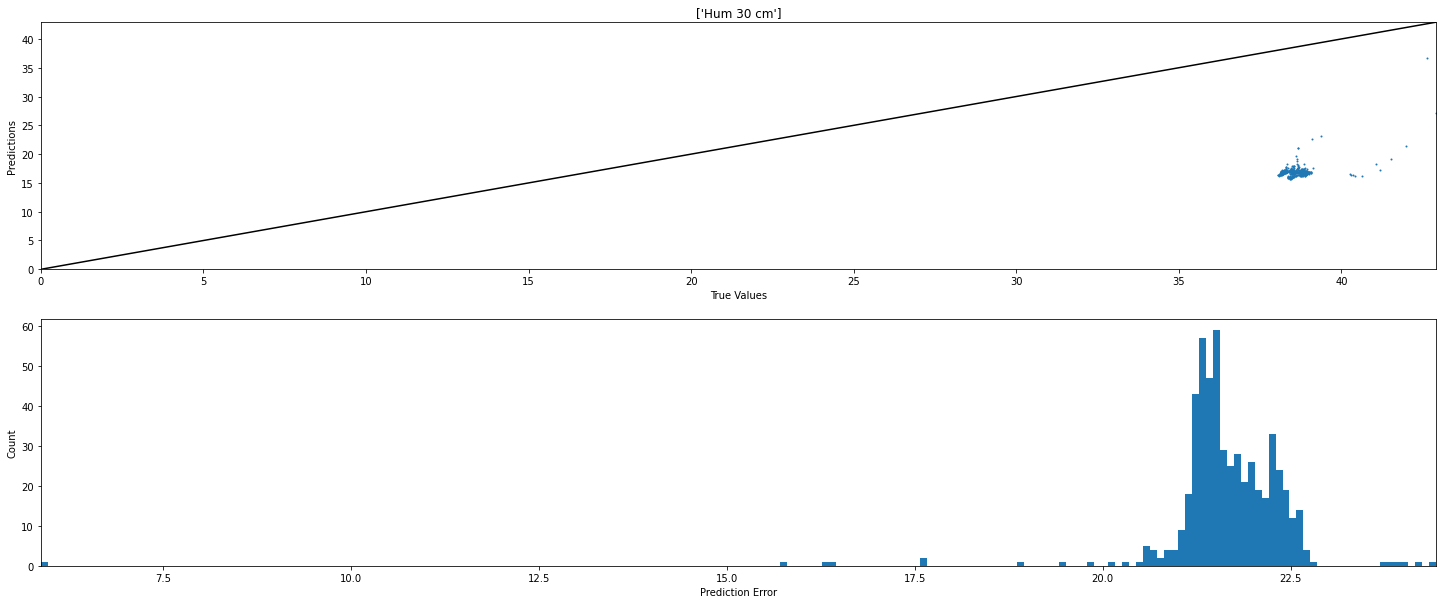

In [38]:
#DNN 10 cm over 30 cm

#prepare data
data=df_30cm
array = data.values
X = array[:,[0,1,2]] 
Y = array[:,3] 
print('Printing data shapes before splitting...')
print('Feature shape: ',X.shape)
print('Target shape: ',Y.shape)

# train-test splitting
test_size = 0.33
seed = 7
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#train-validation splitting
val_size=0.25
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_size, random_state = 1,shuffle=True)

print('\nPrinting data shapes after splitting...')
print('Train feature shape: ',x_train.shape)
print('Train target shape: ',y_train.shape)
print('Validation feature shape: ',x_val.shape)
print('Validation target shape: ',y_val.shape)
print('Test feature shape: ',x_test.shape)
print('Test target shape: ',y_test.shape)

train_y_pred=dnn_10cm.predict(x_train)
val_y_pred=dnn_10cm.predict(x_val)
test_y_pred=dnn_10cm.predict(x_test)

print('Train predictions shape: ',train_y_pred.shape)
print('Validation predictions shape: ',val_y_pred.shape)
print('Test predictions shape: ',test_y_pred.shape)

rmse_train_dnn_10cm_over_30cm = mean_squared_error(y_train,train_y_pred,squared=False)
rmse_val_dnn_10cm_over_30cm = mean_squared_error(y_val,val_y_pred,squared=False)
rmse_test_dnn_10cm_over_30cm = mean_squared_error(y_test,test_y_pred,squared=False)

print('RMSE - Train: {:.3f} Val: {:.3f} Test: {:.3f}'.format(rmse_train_dnn_10cm_over_30cm,rmse_val_dnn_10cm_over_30cm,rmse_test_dnn_10cm_over_30cm))

target_data=['Hum 30 cm']
plot_prediction_results_single_output(y_test,test_y_pred,target_data,200)

Printing data shapes before splitting...
Feature shape:  (1641, 3)
Target shape:  (1641,)

Printing data shapes after splitting...
Train feature shape:  (824, 3)
Train target shape:  (824,)
Validation feature shape:  (275, 3)
Validation target shape:  (275,)
Test feature shape:  (542, 3)
Test target shape:  (542,)
Train predictions shape:  (824, 1)
Validation predictions shape:  (275, 1)
Test predictions shape:  (542, 1)
RMSE - Train: 20.680 Val: 20.626 Test: 20.599
(542,)
(542, 1)


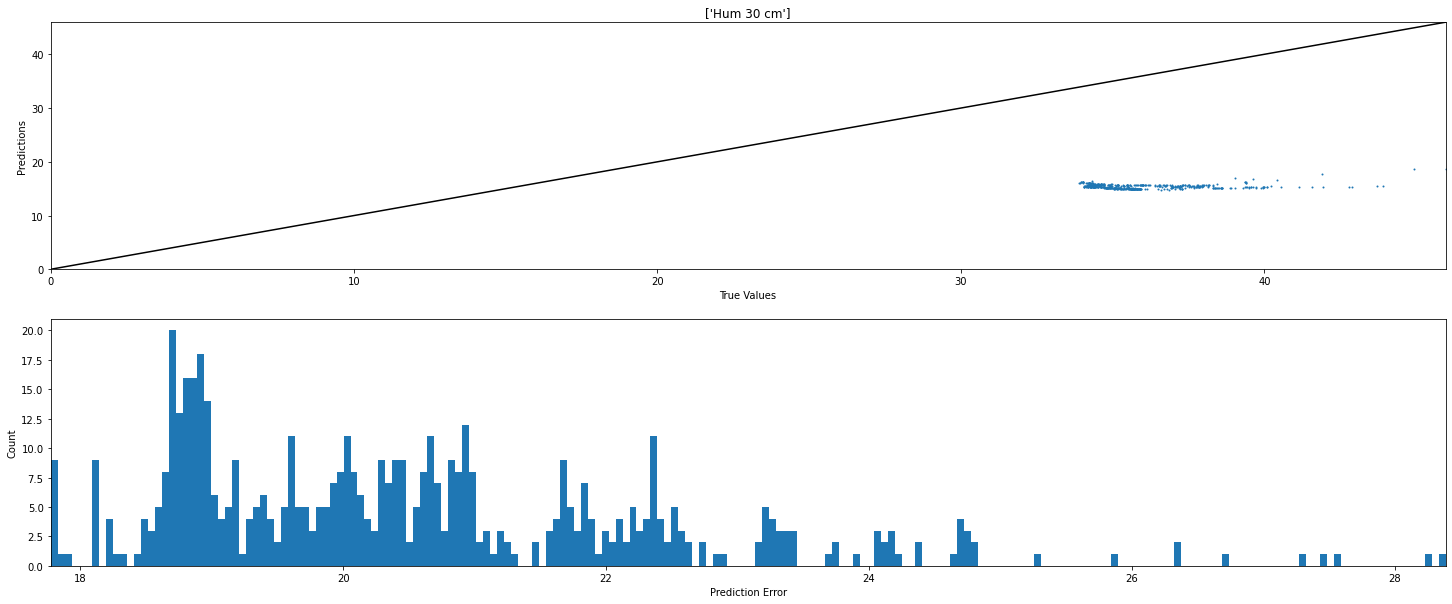

In [39]:
#DNN 10 cm over 20 cm

#prepare data
data=df_20cm
array = data.values
X = array[:,[0,1,2]]
Y = array[:,3]
print('Printing data shapes before splitting...')
print('Feature shape: ',X.shape)
print('Target shape: ',Y.shape)

# train-test splitting
test_size = 0.33
seed = 7
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#train-validation splitting
val_size=0.25
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_size, random_state = 1,shuffle=True)

print('\nPrinting data shapes after splitting...')
print('Train feature shape: ',x_train.shape)
print('Train target shape: ',y_train.shape)
print('Validation feature shape: ',x_val.shape)
print('Validation target shape: ',y_val.shape)
print('Test feature shape: ',x_test.shape)
print('Test target shape: ',y_test.shape)

train_y_pred=dnn_10cm.predict(x_train)
val_y_pred=dnn_10cm.predict(x_val)
test_y_pred=dnn_10cm.predict(x_test)

print('Train predictions shape: ',train_y_pred.shape)
print('Validation predictions shape: ',val_y_pred.shape)
print('Test predictions shape: ',test_y_pred.shape)

rmse_train_dnn_10cm_over_20cm = mean_squared_error(y_train,train_y_pred,squared=False)
rmse_val_dnn_10cm_over_20cm = mean_squared_error(y_val,val_y_pred,squared=False)
rmse_test_dnn_10cm_over_20cm = mean_squared_error(y_test,test_y_pred,squared=False)

print('RMSE - Train: {:.3f} Val: {:.3f} Test: {:.3f}'.format(rmse_train_dnn_10cm_over_20cm,rmse_val_dnn_10cm_over_20cm,rmse_test_dnn_10cm_over_20cm))

target_data=['Hum 30 cm']
plot_prediction_results_single_output(y_test,test_y_pred,target_data,200)

###Comparison

Text(0, 0.5, 'RMSE')

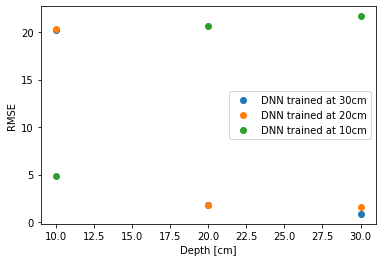

In [42]:
#Plot different RMSEs obtained using the different DNNs

depth=np.array([10,20,30])
rmse_dnn_30cm=[rmse_test_dnn_30cm_over_10cm, rmse_test_dnn_30cm_over_20cm, rmse_test_30cm]
rmse_dnn_20cm=[rmse_test_dnn_20cm_over_10cm, rmse_test_20cm, rmse_test_dnn_20cm_over_30cm]
rmse_dnn_10cm=[rmse_test_10cm, rmse_test_dnn_10cm_over_20cm, rmse_test_dnn_10cm_over_30cm]

plt.scatter(depth, rmse_dnn_30cm, label='DNN trained at 30cm')
plt.scatter(depth, rmse_dnn_20cm, label='DNN trained at 20cm')
plt.scatter(depth, rmse_dnn_10cm, label='DNN trained at 10cm')
plt.legend()
plt.xlabel('Depth [cm]')
plt.ylabel('RMSE')

In generale, misure effettuate a 20 cm e 30 cm mostrano analogie. Infatti, i modelli allenati ad una di queste due profondità possono essere facilmente utilizzati per stimare l'umidità anche per l'altra profondità. Risulta inoltra evidente che le misure effettuate a 10 cm di profondità hanno una distribuzione troppo diversa dalle altre e di conseguenza gli altri modelli non sono in grado di comportarsi allo stesso modo.

Il modello allenato a 10 cm di profondità continua a mostrare i problemi evindenziati finora ed è stato incluso esclusivamente per completezza dell'analisi. Il RMSE misurato testimonia ancor di più quanto sia fallace in altri casi.

#Sviluppi futuri

Per concludere, i risultati evidenziano come, con i giusti dati, è possibile stimare l'umidità di un terreno a determinate profondità sfruttando dati di altri sensori in campo o esclusivamente le caratteristiche della propagazione elettromagnetica sotterranea con sufficiente accuratezza. Ritengo però che ci sia molto altro che si può fare ed in particolare le direzioni che vorrei prendere nel futuro sono le seguenti:

*   Introduzione dei dati meteorologici nel database: è immediato pensare che precipitazioni o altri eventi atmosferici possano influire molto sui dati raccolti sul terreno, di conseguenza l'integrazione di dati raccolti da una stazione meteo nella zona del campo potrebbe migliorare ancor di più il modello (e potenzialmente aiutare nella stima di profondità più basse come 10 cm);

*   Utilizzo di tecniche di transfer learning per l'utilizzo dello stesso modello su più terreni: cosa succederebbe se utilizzassimo un modello allenato su un terreno specifico (come il meleto in questo caso) su un terreno diverso? Il tipo di piantagione influisce in maniera molto importante sull'umidità del terreno e la frequenza con cui questo va irrigato, in quanto la crescita delle piante è diversa. E' però ragionevole pensare che ci possano essere dei punti in comune tra piantagioni appartenenti alla stessa famiglia. Utilizzare tecniche di transfer learning potrebbe essere un buon metodo per allenare un modello su uno specifico campo ma poi sfruttarlo su piantagioni diverse senza necessità di effettuare nuove sessioni di raccolta dati.

